In [32]:
%matplotlib inline
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, BayesianRidge, ElasticNetCV

import matplotlib.pylab as plt
import missingno as msno


from sklearn.model_selection import cross_val_score
import sklearn.metrics

from dmba import regressionSummary, gainsChart, liftChart
from dmba import adjusted_r2_score, AIC_score, BIC_score

In [33]:
data_df = pd.read_csv('Big_Mart_Sales.csv')

In [34]:
data_df.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.0160,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.14
1,DRC01,5.92,Regular,0.0193,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.0168,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27
3,FDX07,19.20,Regular,0.0000,Fruits and Vegetables,182.10,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.0000,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71
5,FDP36,10.40,Regular,0.0000,Baking Goods,51.40,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.61
6,FDO10,13.65,Regular,0.0127,Snack Foods,57.66,OUT013,1987,High,Tier 3,Supermarket Type1,343.55
7,FDP10,NaN,Low Fat,0.1275,Snack Foods,107.76,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.76
8,FDH17,16.20,Regular,0.0167,Frozen Foods,96.97,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.60
9,FDU28,19.20,Regular,0.0944,Frozen Foods,187.82,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.54


In [35]:
# get rid of nonessential variables - but why are we removing these variables?

data_df = data_df.drop('Item_Identifier', axis=1)

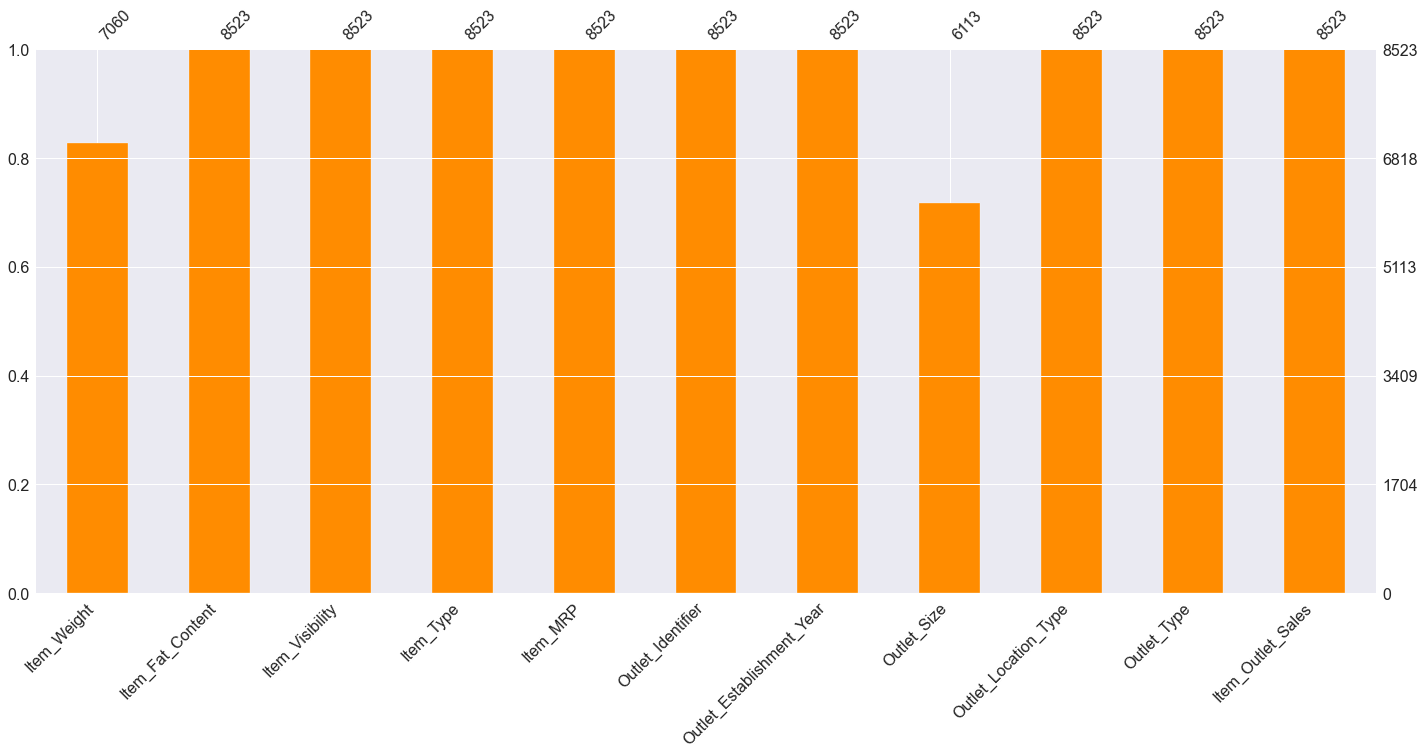

In [36]:
msno.bar(data_df, color='darkorange')

### Exploratory Data Analyses Here

Imported AutoViz_Class version: 0.0.81. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 saves plots in your local machine under AutoViz_Plots directory and does not display charts.
Shape of your Data Set: (8523, 11)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  3
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  6
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0


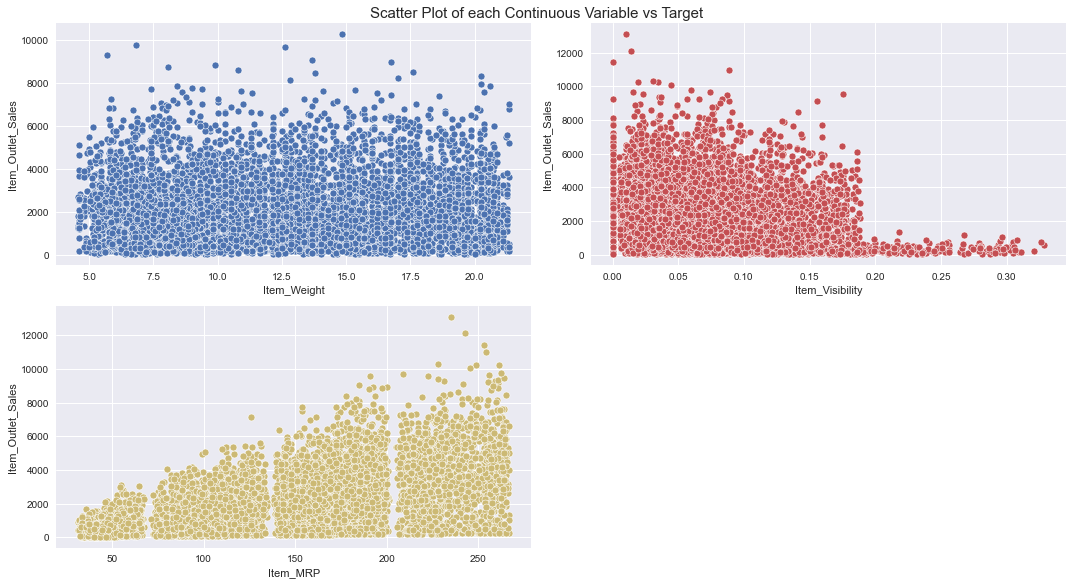

Number of All Scatter Plots = 6


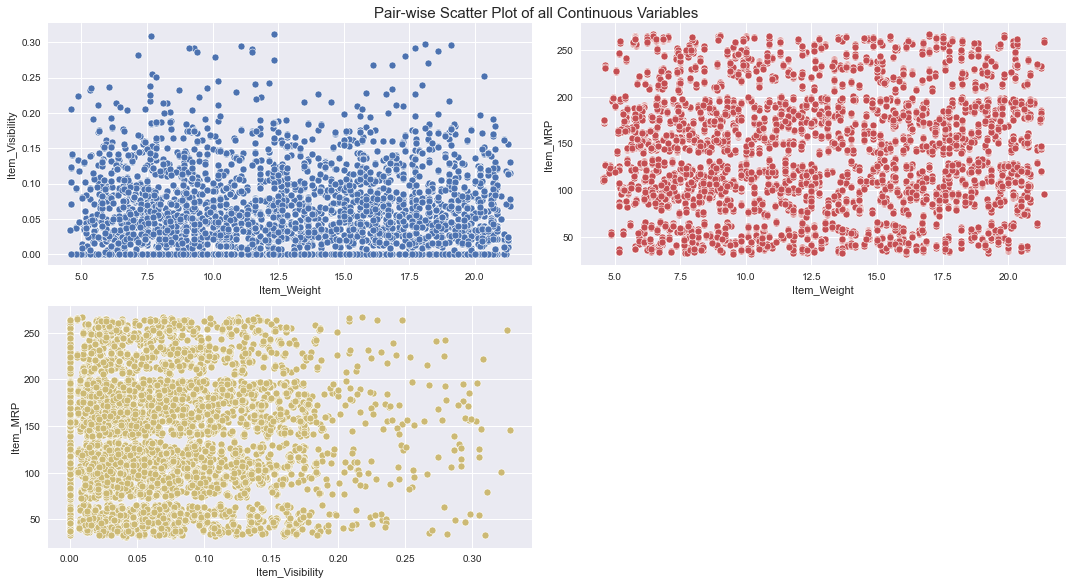

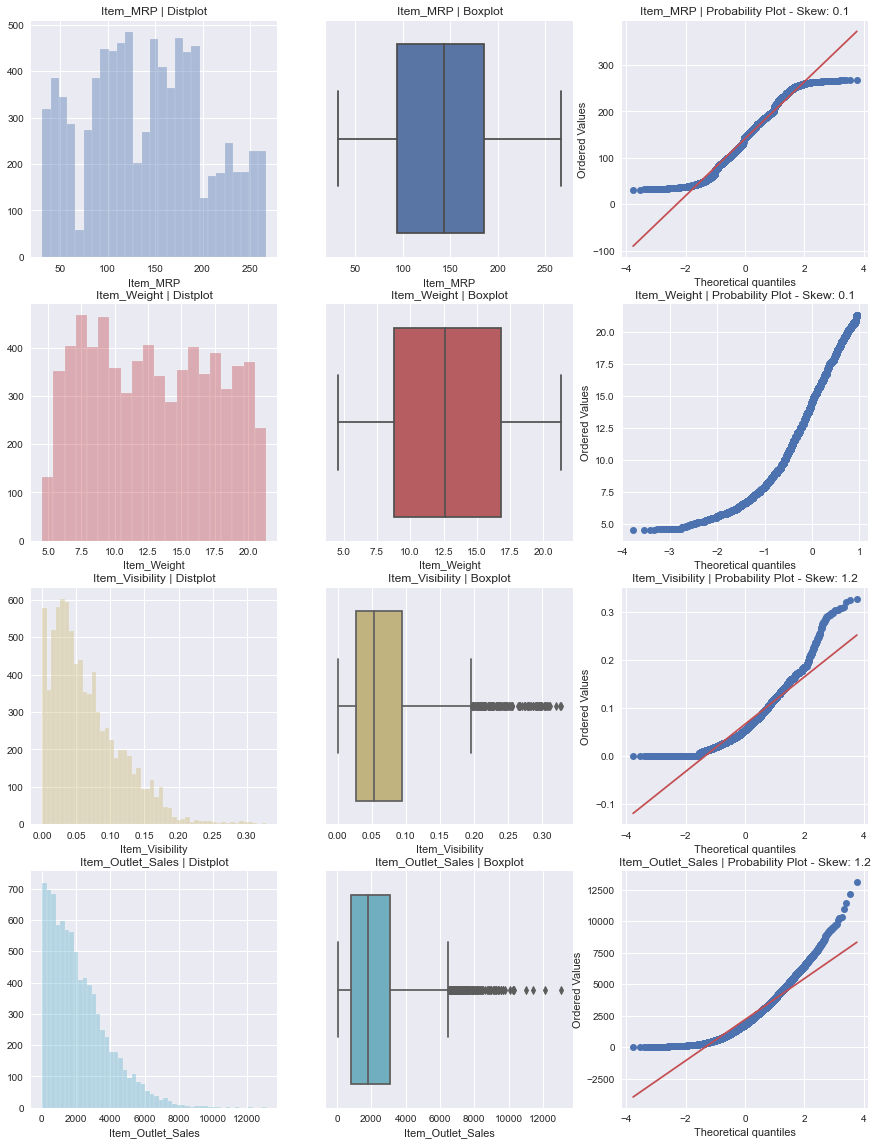

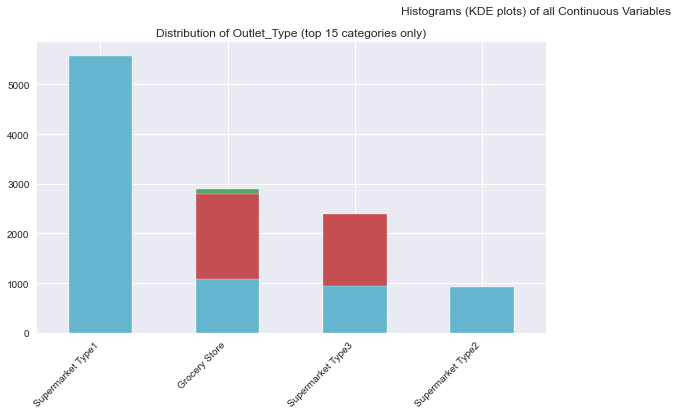

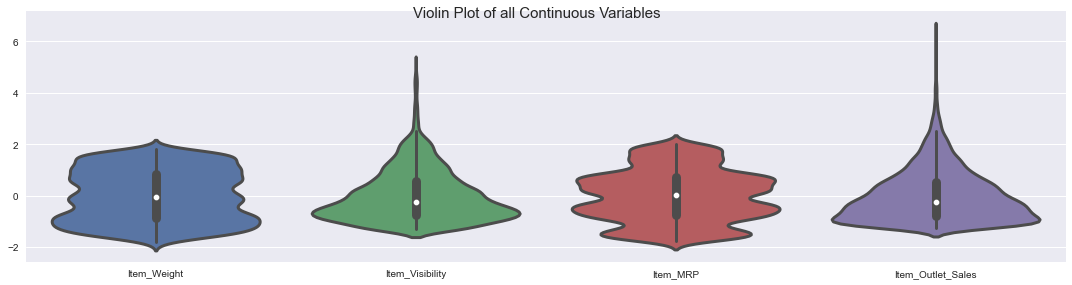

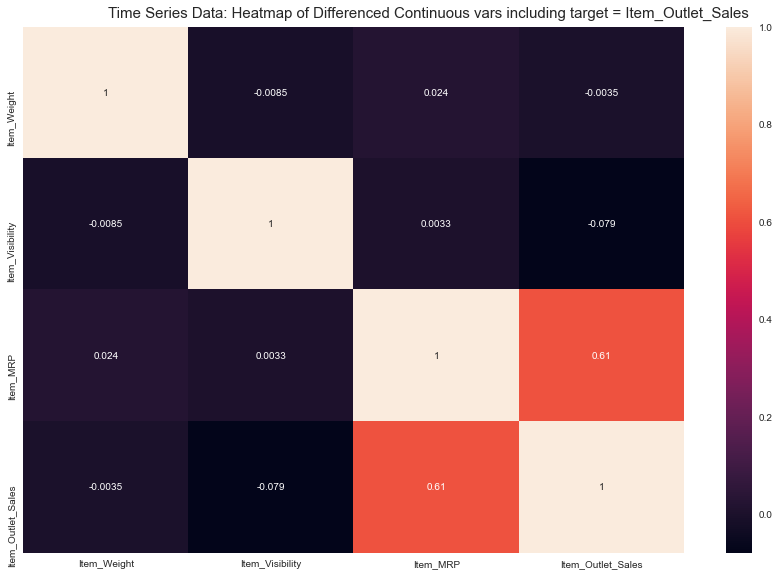

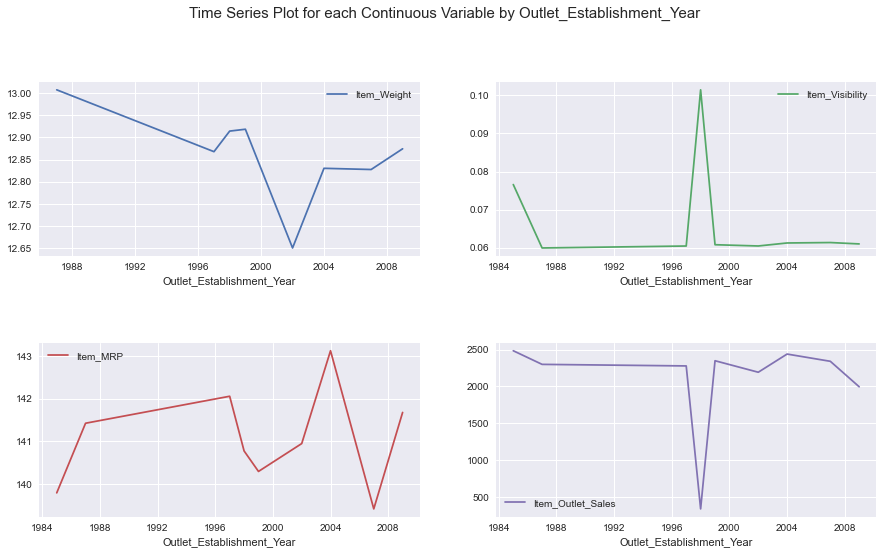

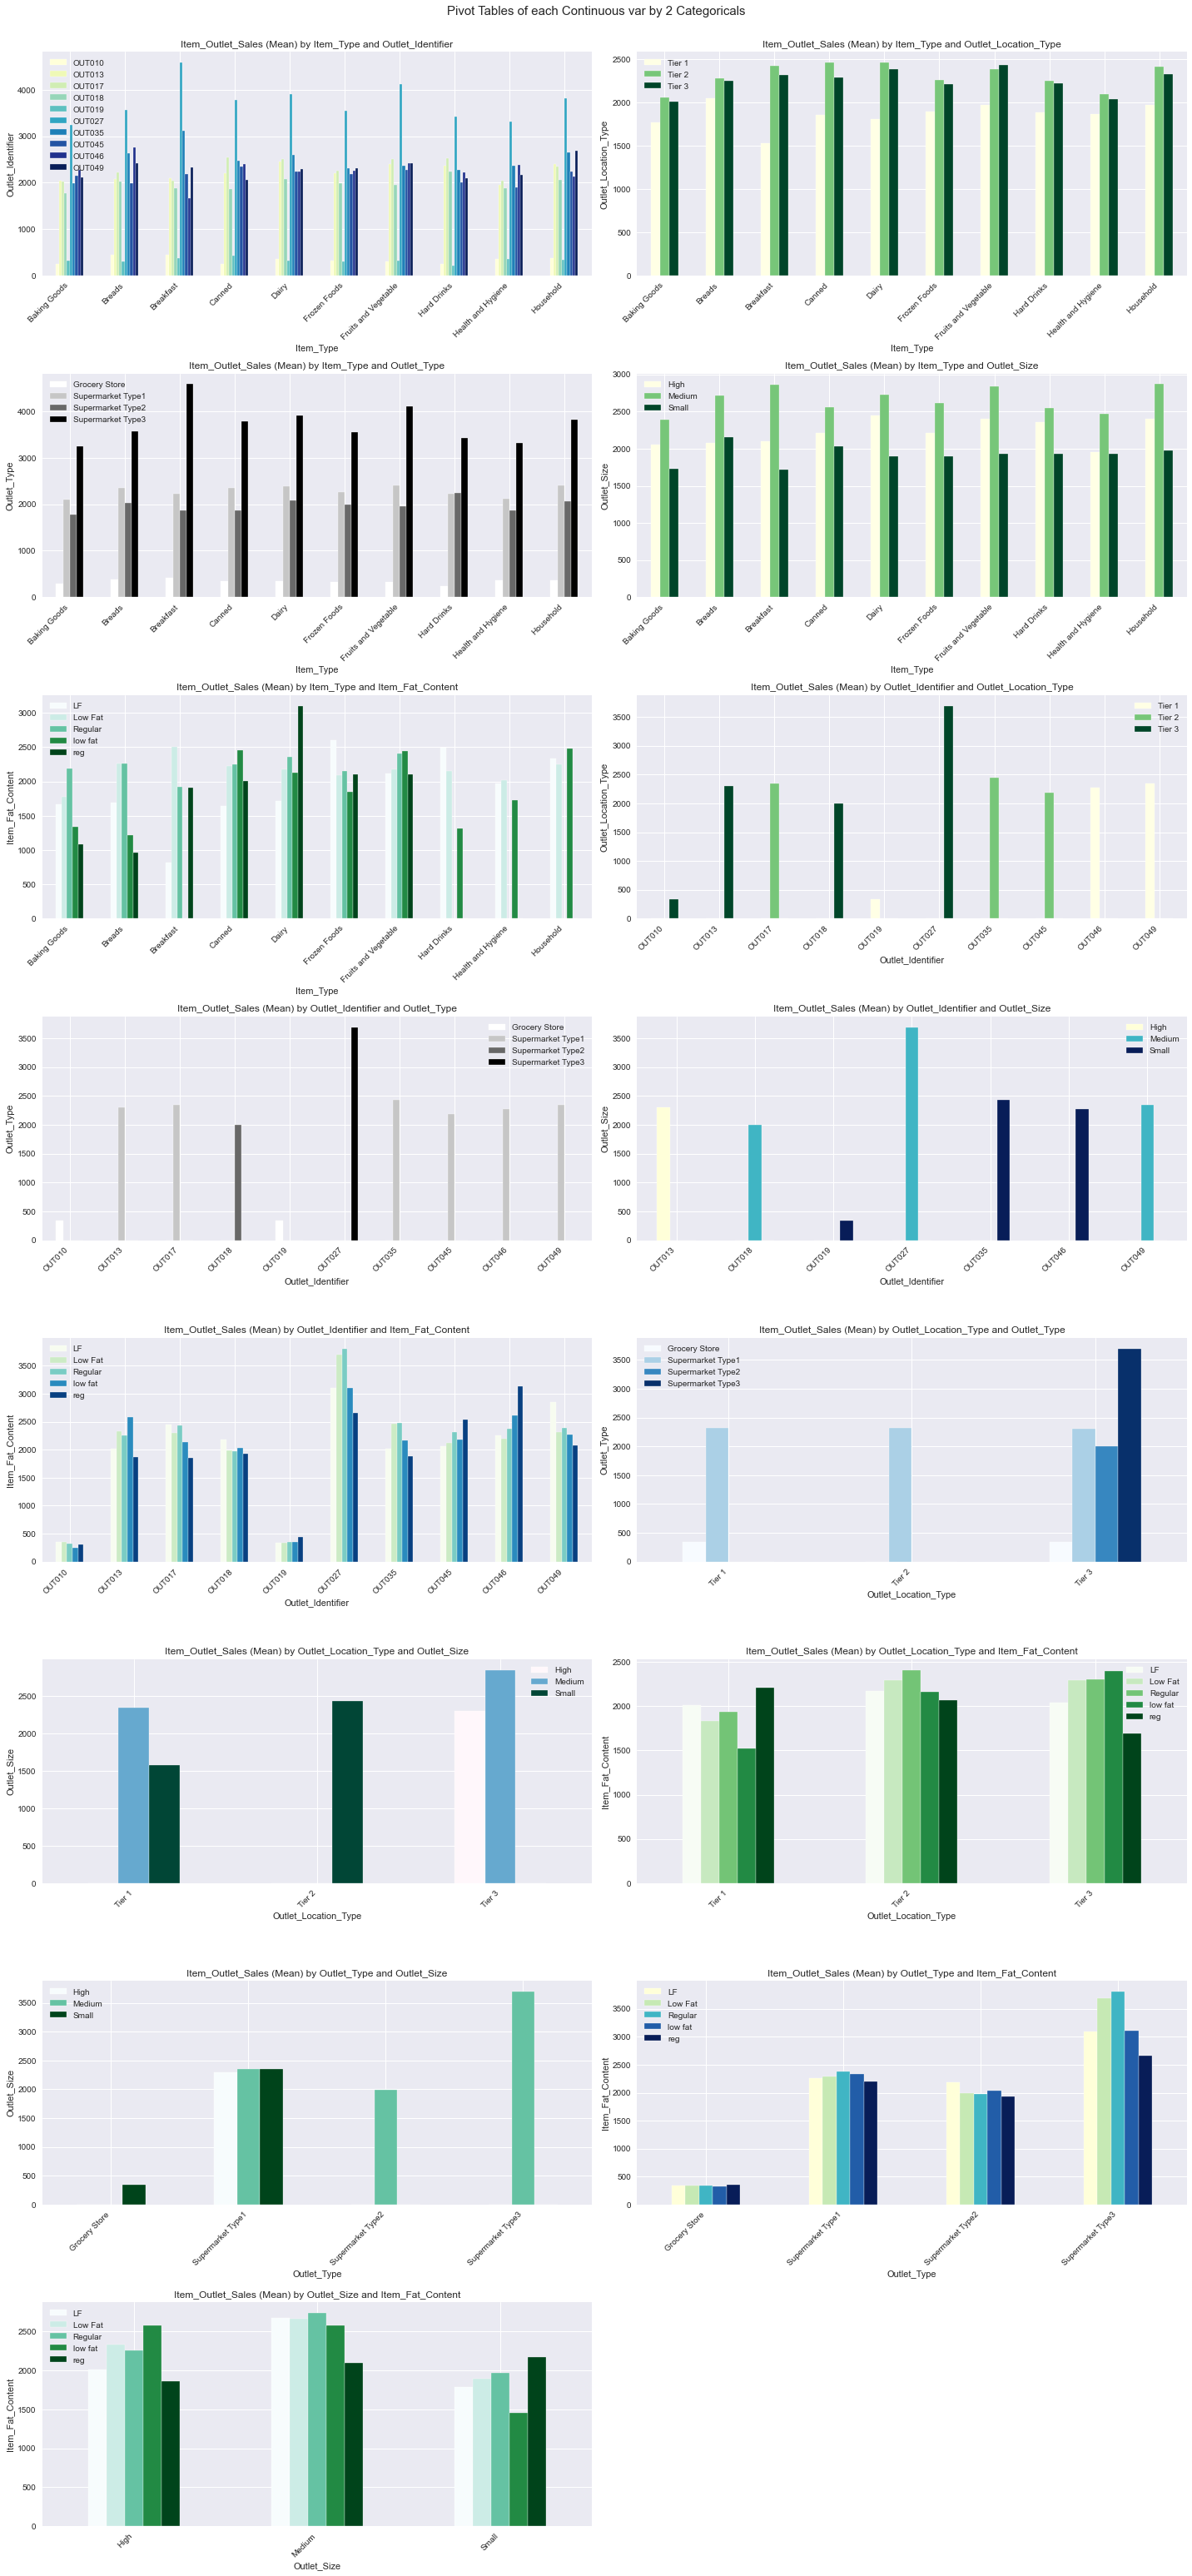

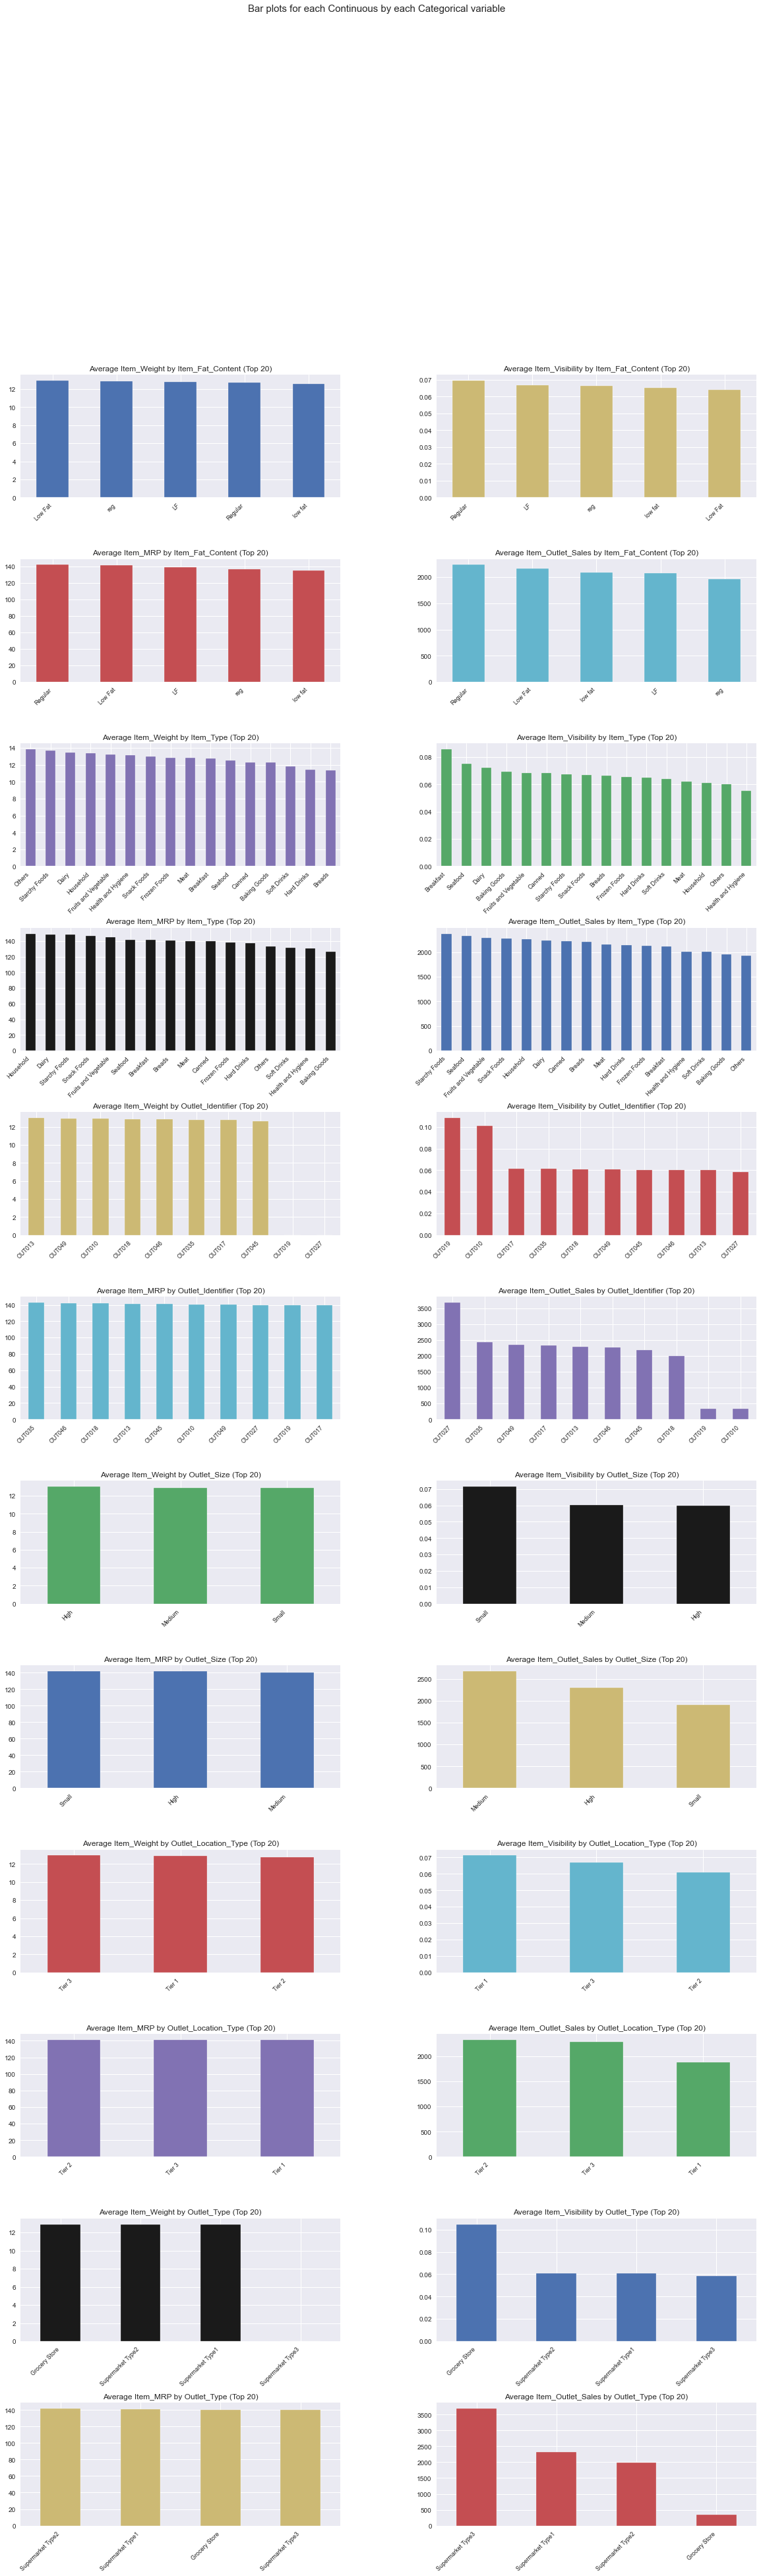

All Plots done
Time to run AutoViz (in seconds) = 9.785

 ###################### VISUALIZATION Completed ########################


In [5]:
from autoviz.AutoViz_Class import AutoViz_Class

AV = AutoViz_Class()

filename = ""
separator = ""

dft = AV.AutoViz(
    filename,
    sep = separator,
    depVar='Item_Outlet_Sales',
    dfte = data_df,
    header=0,
    verbose=0,
    lowess=False,
    chart_format="png",
    max_rows_analyzed=10000,
    max_cols_analyzed=50,
)

In [6]:
# isolate predictors separate from the response variable, and we're using all predictors

X = data_df.drop(columns=["Item_Outlet_Sales"])

y = data_df["Item_Outlet_Sales"]

In [7]:
# dummy code the predictors; THIS STEP OCCURS BEFORE TRAIN/TEST SPLIT

X = pd.get_dummies(X, drop_first = True)

In [8]:
X.shape

(8523, 39)

In [9]:
# let's take a look at all of the predictors after dummy coding; what measures do these employ?
pd.DataFrame(X.columns)

,0
0,Item_Weight
1,Item_Visibility
2,Item_MRP
3,Outlet_Establishment_Year
4,Item_Fat_Content_Low Fat
5,Item_Fat_Content_Regular
6,Item_Fat_Content_low fat
7,Item_Fat_Content_reg
8,Item_Type_Breads
9,Item_Type_Breakfast


### EXPLANATORY MODEL HERE

In [10]:
# MISSING VALUE IMPUTATION HERE FOR EXPLANATORY MODEL ONLY

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 6)

X_imp = imputer.fit_transform(X)

X_imp = pd.DataFrame(X_imp, columns = X.columns)

In [11]:
algo = LinearRegression()

param_grid = {}

In [12]:
gridSearch = GridSearchCV(algo, param_grid, cv=10)

gridSearch.fit(X_imp, y)

print('Initial parameters: ', gridSearch.best_params_)

explanatory_model = gridSearch.best_estimator_

Initial parameters:  {}


In [13]:
# print coefficients from the explanatory model
print('intercept ', explanatory_model.intercept_)

print(pd.DataFrame({'Predictor': X.columns, 'coefficient': explanatory_model.coef_}))

intercept  60406.288400120364
                          Predictor  coefficient
0                       Item_Weight     0.401066
1                   Item_Visibility  -304.322680
2                          Item_MRP    15.562204
3         Outlet_Establishment_Year   -31.095813
4          Item_Fat_Content_Low Fat    31.361171
5          Item_Fat_Content_Regular    75.400022
6          Item_Fat_Content_low fat    77.997315
7              Item_Fat_Content_reg   -29.696921
8                  Item_Type_Breads     4.706149
9               Item_Type_Breakfast     6.728236
10                 Item_Type_Canned    24.965571
11                  Item_Type_Dairy   -42.500398
12           Item_Type_Frozen Foods   -27.996530
13  Item_Type_Fruits and Vegetables    29.353332
14            Item_Type_Hard Drinks    -0.829966
15     Item_Type_Health and Hygiene   -11.261426
16              Item_Type_Household   -39.892368
17                   Item_Type_Meat    -1.375842
18                 Item_Type_Others   -

## PREDICTIVE MODELS HERE

In [14]:
# split into training and holdout (test) datasets

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.5, random_state=1)

In [15]:
# MISSING VALUE IMPUTATION HERE (AFTER THE TRAIN/TEST SPLIT)

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 6)

train_X = imputer.fit_transform(train_X)
test_X = imputer.transform(test_X)

### Three methods of regularization
#### 1)  L1 = Least absolute shrinkage and selection operator (Lasso)
#### 2)  L2 = Ridge regression
#### 3)  Bayesian ridge regression is a special form of L2

In [16]:
# Standardization with Z-score method

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

train_X = pd.DataFrame(train_X, columns = X.columns)

In [17]:
# LassoCV has hyperparameters that we can adjust - discuss each one.
# normalize = True sets an l2 normalization scheme (this may not be the best method for normalization)
# cv = 10 sets the number of folds of cross validation
# n_alphas = 50 sets the number of regularization values that will be tested
# max_iter = 100 sets the number of iterations that will be tested for convergence (if the model does not converge, increase)
# pre_compute = 'auto' allows the algorithm the option to invoke a precomputed Gram matrix to speed up calculations

train_X = pd.DataFrame(train_X) # convert numpy array back to pandas dataframe

lasso_cv = LassoCV(normalize=False, cv=10, n_alphas=50, max_iter=1000, precompute='auto')

lasso_cv.fit(train_X, train_y)

LassoCV(cv=10, n_alphas=50)

In [18]:
# DISPLAY MODEL PERFORMANCE

print("LassoCV Model")

regressionSummary(train_y, lasso_cv.predict(train_X))
print()
regressionSummary(test_y, lasso_cv.predict(test_X))

print('Lasso-CV chosen regularization: ', lasso_cv.alpha_)
print()
print(pd.DataFrame({'Predictor': train_X.columns, 'coefficient': lasso_cv.coef_}))

LassoCV Model

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1111.4462
            Mean Absolute Error (MAE) : 823.6776
          Mean Percentage Error (MPE) : -6.5264
Mean Absolute Percentage Error (MAPE) : 100.0274


Regression statistics

                      Mean Error (ME) : 9.2128
       Root Mean Squared Error (RMSE) : 1145.6820
            Mean Absolute Error (MAE) : 847.1672
          Mean Percentage Error (MPE) : -3.2043
Mean Absolute Percentage Error (MAPE) : 104.3139
Lasso-CV chosen regularization:  7.030380754729441

                          Predictor  coefficient
0                       Item_Weight     0.824156
1                   Item_Visibility   -20.380600
2                          Item_MRP   971.262004
3         Outlet_Establishment_Year     0.000000
4          Item_Fat_Content_Low Fat    -0.000000
5          Item_Fat_Content_Regular     4.232517
6          Item_Fat_Content_low fat    -2.499313
7      

1.0


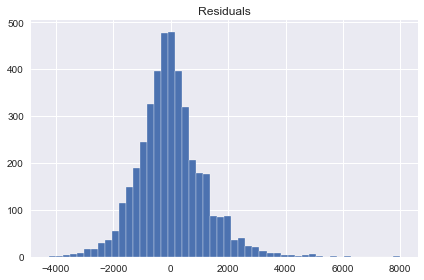

In [19]:
# Display a histogram of the residuals to determine whether to use RMSE or MAE

%matplotlib inline

data_lm_pred = lasso_cv.predict(test_X)
all_residuals = test_y - data_lm_pred

# Determine the percentage of datapoints with a residual in [-200000, 200000] = approx. 75\%
print(len(all_residuals[(all_residuals > -200000) & (all_residuals < 200000)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=50)

plt.tight_layout()
plt.show()

In [20]:
# CHECK THE DESCRIPTIVE STATISTICS OF THE RESIDUALS

all_residuals.describe()

count    4262.000000
mean        9.212848
std      1145.779367
min     -4252.235338
25%      -675.224958
50%       -65.923303
75%       585.661498
max      7988.592751
Name: Item_Outlet_Sales, dtype: float64

In [21]:
# Print out the measures of model fit

pred_y = lasso_cv.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, lasso_cv))
print('AIC : ', AIC_score(train_y, pred_y, lasso_cv))
print('BIC : ', BIC_score(train_y, pred_y, lasso_cv))

adjusted r2 :  0.5654728096451924
AIC :  71942.53688873889
BIC :  72203.18451403239


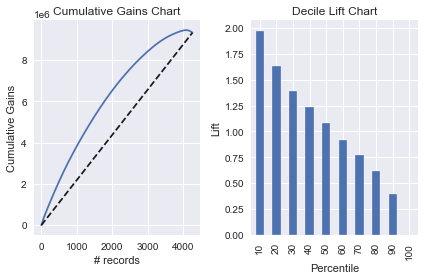

In [22]:
# Gain and lift charts for inspecting model goodness of fit

pred_v = pd.Series(lasso_cv.predict(train_X))

pred_v = pred_v.sort_values(ascending=False)

fig,axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(pred_v, ax=axes[0])
ax.set_ylabel('Cumulative Gains')
ax.set_title("Cumulative Gains Chart")

ax = liftChart(pred_v, ax=axes[1], labelBars=False)
ax.set_ylabel("Lift")

plt.tight_layout()
plt.show()

In [23]:
# RidgeCV has hyperparameters that we can adjust - discuss each one.

ridge_cv = RidgeCV(normalize=False, alphas=(0.01, 0.1, 0.3, 0.5, 0.7, 1.0), cv=10, scoring='neg_mean_absolute_error')

ridge_cv.fit(train_X, train_y)

RidgeCV(alphas=array([0.01, 0.1 , 0.3 , 0.5 , 0.7 , 1.  ]), cv=10,
        scoring='neg_mean_absolute_error')

In [24]:
print("RidgeCV Model")

regressionSummary(train_y, ridge_cv.predict(train_X))
print()
regressionSummary(test_y, ridge_cv.predict(test_X))

print('Ridge-CV chosen regularization: ', ridge_cv.alpha_)
print()

RidgeCV Model

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1110.6864
            Mean Absolute Error (MAE) : 824.0708
          Mean Percentage Error (MPE) : -2.4493
Mean Absolute Percentage Error (MAPE) : 102.1463


Regression statistics

                      Mean Error (ME) : 10.6266
       Root Mean Squared Error (RMSE) : 1147.4721
            Mean Absolute Error (MAE) : 849.0142
          Mean Percentage Error (MPE) : 1.8024
Mean Absolute Percentage Error (MAPE) : 107.0736
Ridge-CV chosen regularization:  1.0



In [25]:
# Print out the measures of model fit

pred_y = ridge_cv.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, ridge_cv))
print('AIC : ', AIC_score(train_y, pred_y, ridge_cv))
print('BIC : ', BIC_score(train_y, pred_y, ridge_cv))

adjusted r2 :  0.5660667596026052
AIC :  71936.70859518975
BIC :  72197.35622048324


In [26]:
bayesianRidge = BayesianRidge(normalize=False)

bayesianRidge.fit(train_X, train_y)

BayesianRidge()

In [27]:
print("Bayesian Ridge Model")

regressionSummary(train_y, bayesianRidge.predict(train_X))
print()
regressionSummary(test_y, bayesianRidge.predict(test_X))

print('Bayesian ridge chosen regularization: ', bayesianRidge.lambda_ / bayesianRidge.alpha_)

Bayesian Ridge Model

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1110.7209
            Mean Absolute Error (MAE) : 823.8421
          Mean Percentage Error (MPE) : -3.5948
Mean Absolute Percentage Error (MAPE) : 101.5265


Regression statistics

                      Mean Error (ME) : 10.3465
       Root Mean Squared Error (RMSE) : 1147.4197
            Mean Absolute Error (MAE) : 848.7284
          Mean Percentage Error (MPE) : 0.4587
Mean Absolute Percentage Error (MAPE) : 106.3508
Bayesian ridge chosen regularization:  21.203755929802853


In [28]:
# Print out the measures of model fit

pred_y = bayesianRidge.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, bayesianRidge))
print('AIC : ', AIC_score(train_y, pred_y, bayesianRidge))
print('BIC : ', BIC_score(train_y, pred_y, bayesianRidge))

adjusted r2 :  0.5660397316903867
AIC :  71936.97398704449
BIC :  72197.62161233799


In [29]:
# ElasticNetCV model that combines LASSO and Ridge regression

elastic_cv = ElasticNetCV(normalize=False, cv=10, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=100)

elastic_cv.fit(train_X, train_y)

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1])

In [30]:
print("ElasticNet Model")

regressionSummary(train_y, elastic_cv.predict(train_X))
regressionSummary(test_y, elastic_cv.predict(test_X))

# print coefficients
print('intercept ', elastic_cv.intercept_)
print(pd.DataFrame({'Predictor': train_X.columns, 'coefficient': elastic_cv.coef_}))
print('ElasticNet-CV chosen regularization: ', elastic_cv.alpha_)
print('ElasticNet-CV chosen l1 ratio: ', elastic_cv.l1_ratio_)

ElasticNet Model

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1111.4176
            Mean Absolute Error (MAE) : 823.6711
          Mean Percentage Error (MPE) : -6.4449
Mean Absolute Percentage Error (MAPE) : 100.0662

Regression statistics

                      Mean Error (ME) : 9.2359
       Root Mean Squared Error (RMSE) : 1145.7036
            Mean Absolute Error (MAE) : 847.1865
          Mean Percentage Error (MPE) : -3.1056
Mean Absolute Percentage Error (MAPE) : 104.3647
intercept  2186.9775123210516
                          Predictor  coefficient
0                       Item_Weight     0.977128
1                   Item_Visibility   -20.405497
2                          Item_MRP   971.394420
3         Outlet_Establishment_Year     0.000000
4          Item_Fat_Content_Low Fat    -0.000000
5          Item_Fat_Content_Regular     4.307751
6          Item_Fat_Content_low fat    -2.616937
7              Item_Fat_Con

In [31]:
# Print out the measures of model fit

pred_y = elastic_cv.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, elastic_cv))
print('AIC : ', AIC_score(train_y, pred_y, elastic_cv))
print('BIC : ', BIC_score(train_y, pred_y, elastic_cv))

adjusted r2 :  0.5654951716166422
AIC :  71942.31760024707
BIC :  72202.96522554057
